##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Constructing a Text Generation Model


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c03_nlp_constructing_text_generation_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c03_nlp_constructing_text_generation_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Using most of the techniques you've already learned, it's now possible to generate new text by predicting the next word that follows a given seed word. To practice this method, we'll use the [Kaggle Song Lyrics Dataset](https://www.kaggle.com/mousehead/songlyrics).

## Import TensorFlow and related functions

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

## Get the Dataset

As noted above, we'll utilize the [Song Lyrics dataset](https://www.kaggle.com/mousehead/songlyrics) on Kaggle.

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2025-01-02 00:33:33--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 142.250.98.139, 142.250.98.138, 142.250.98.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.98.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2025-01-02 00:33:33--  https://drive.usercontent.google.com/download?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.107.132, 2607:f8b0:400c:c32::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72436445 (69M) [application/octet-stream]
Saving to: ‘/tmp/songdata.csv’

/tmp/songdata.csv   100%[===================>]  69.08M   132MB/s    in 0.5s    

2025-01-02 00:33:39 (132 M

## **First 10 Songs**

Let's first look at just 10 songs from the dataset, and see how things perform.

### Preprocessing

Let's perform some basic preprocessing to get rid of punctuation and make everything lowercase. We'll then split the lyrics up by line and tokenize the lyrics.

In [3]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [49]:
# Read the dataset from csv - just first 10 songs for now
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:300]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus)

total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'the': 1, 'i': 2, 'you': 3, 'a': 4, 'and': 5, 'to': 6, 'me': 7, 'it': 8, 'in': 9, 'my': 10, 'of': 11, 'that': 12, 'your': 13, "i'm": 14, 'love': 15, 'all': 16, 'for': 17, 'so': 18, 'is': 19, 'on': 20, 'be': 21, 'we': 22, "don't": 23, 'when': 24, 'just': 25, 'la': 26, "you're": 27, 'but': 28, "it's": 29, 'like': 30, 'do': 31, 'know': 32, 'with': 33, 'now': 34, 'what': 35, 'no': 36, 'can': 37, 'have': 38, 'was': 39, 'got': 40, 'take': 41, 'one': 42, 'if': 43, 'get': 44, 'never': 45, 'yeah': 46, 'time': 47, 'down': 48, 'go': 49, 'see': 50, 'she': 51, 'up': 52, "can't": 53, 'out': 54, 'this': 55, 'baby': 56, 'oh': 57, 'more': 58, 'are': 59, 'want': 60, 'away': 61, 'night': 62, 'feel': 63, 'as': 64, 'will': 65, 'gonna': 66, 'from': 67, 'say': 68, 'way': 69, 'make': 70, 'at': 71, 'tell': 72, "there's": 73, 'let': 74, 'they': 75, 'not': 76, "i've": 77, 'gotta': 78, 'come': 79, 'he': 80, 'could': 81, 'how': 82, 'here': 83, 'day': 84, 'girl': 85, 'too': 86, 'there': 87, "i'll": 88, 'think': 89

### Create Sequences and Labels

After preprocessing, we next need to create sequences and labels. Creating the sequences themselves is similar to before with `texts_to_sequences`, but also including the use of [N-Grams](https://towardsdatascience.com/introduction-to-language-models-n-gram-e323081503d9); creating the labels will now utilize those sequences as well as utilize one-hot encoding over all potential output words.

In [50]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [51]:
# Check out how some of our data is being stored
# The Tokenizer has just a single index per word
print(tokenizer.word_index['know'])
print(tokenizer.word_index['feeling'])
# Input sequences will have multiple indexes
print(input_sequences[5])
print(input_sequences[6])
# And the one hot labels will be as long as the full spread of tokenized words
print(one_hot_labels[5])
print(one_hot_labels[6])

32
129
[  0   0   0   0   0   0   0   0   0   0   0   0   0 115  71  90 206  29
   4]
[   0    0    0    0    0    0    0    0    0    0    0    0  115   71
   90  206   29    4 1287]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


### Train a Text Generation Model

Building an RNN to train our text generation model will be very similar to the sentiment models you've built previously. The only real change necessary is to make sure to use Categorical instead of Binary Cross Entropy as the loss function - we could use Binary before since the sentiment was only 0 or 1, but now there are hundreds of categories.

From there, we should also consider using *more* epochs than before, as text generation can take a little longer to converge than sentiment analysis, *and* we aren't working with all that much data yet. I'll set it at 200 epochs here since we're only use part of the dataset, and training will tail off quite a bit over that many epochs.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, MultiHeadAttention

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(MultiHeadAttention(key_dim=20, num_heads=1))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 19)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 19, 64)         │         31,680 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 40)             │         13,600 │ embedding_5[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 40)             │          3,300 │ bidirectional_5[0][0], │
│ (MultiHeadAttention)      │                        │                │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 495)            │         20,295 │ multi_head_attention_… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 68,875 (269.04 KB)

 Trainable params: 68,875 (269.04 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, MultiHeadAttention, Dense, GlobalAveragePooling1D

# Define the model using Functional API
input_seq = layers.Input(shape=(max_sequence_len-1,), dtype=tf.int32)  # Input for the sequence

# Embedding layer (converts word indices to embeddings)
embedding_layer = Embedding(total_words, 64, input_length=max_sequence_len-1)(input_seq)

# Add Bidirectional LSTM (with return_sequences=True to preserve the full sequence)
rnn_output = Bidirectional(LSTM(20, return_sequences=True))(embedding_layer)


# Define the MultiHeadAttention layer
# Here we use `query` as the output of the RNN, and `value` can be the same sequence
attention_output = MultiHeadAttention(key_dim=20, num_heads=1)(rnn_output, rnn_output)

# Apply GlobalAveragePooling1D to reduce the sequence dimension to a single vector
pooled_output = GlobalAveragePooling1D()(attention_output)

# Dense layer to predict the next word (output layer)
output = Dense(total_words, activation='softmax')(pooled_output)

# Define the model
model = Model(inputs=input_seq, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 19)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_16 (Embedding)  │ (None, 19, 64)         │        277,248 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_16          │ (None, 19, 40)         │         13,600 │ embedding_16[0][0]     │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_21   │ (None, 19, 40)         │          3,300 │ bidirectional_16[0][0… │
│ (MultiHeadAttention)      │                        │                │ bidirectional_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 40)             │              0 │ multi_head_attention_… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 4332)           │        177,612 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 471,760 (1.80 MB)

 Trainable params: 471,760 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history = model.fit(input_sequences, one_hot_labels, epochs=200, verbose=1,initial_epoch =50)

Epoch 1/50
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.0430 - loss: 6.5406
Epoch 2/50
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.0583 - loss: 5.7744
Epoch 3/50
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.0938 - loss: 5.4132
Epoch 4/50
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.1126 - loss: 5.1423
Epoch 5/50
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.1319 - loss: 4.9174
Epoch 6/50
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.1660 - loss: 4.6698
Epoch 7/50
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.1843 - loss: 4.5030
Epoch 8/50
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.1991 - loss: 4.3314
Epoch 9/50
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2161 - loss: 4.2221
Epoch 10/50
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.2325 - loss: 4.0793
Epoch 11/50
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2436 - loss: 3.9699
Epoch 12/50
183

In [22]:
attention_layer = MultiHeadAttention(key_dim=20, num_heads=1)

tf.Tensor(
[[[-1.478642   -0.46976313 -0.5561583  -0.61296433  1.2848102
   -0.70194983 -2.193968   -1.4284563   0.60956556  1.0547559
   -0.11173092  0.5306785  -0.92702633 -0.9336925   0.16918008
    0.27658352 -0.8104988   0.4432599  -0.48518974 -0.33210048]]], shape=(1, 1, 20), dtype=float32)
Attention Output Shape: (1, 1, 20)
Attention Scores Shape: (1, 1, 1, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


### View the Training Graph

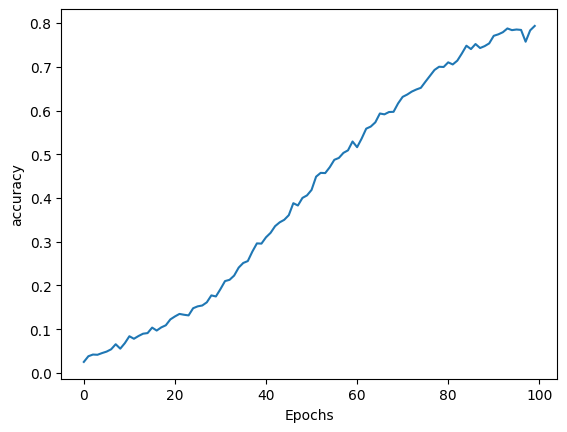

In [46]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

### Generate new lyrics!

It's finally time to generate some new lyrics from the trained model, and see what we get. To do so, we'll provide some "seed text", or an input sequence for the model to start with. We'll also decide just how long of an output sequence we want - this could essentially be infinite, as the input plus the previous output will be continuously fed in for a new output word (at least up to our max sequence length).

In [56]:
seed_text = "You are my"
next_words = 100

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━